In [1]:
import csv
import numpy as np
import cv2

target_shape = (80, 40) #original size 320, 160
nb_cams = 3
angle_shift = 0.1

def load_csv(directory=''):
    #data_dirs = ['dataset-1', 'dataset-2', 'dataset-3', 'dataset-4', 'dataset-5', 'dataset-water', 'data']
    data_dirs = ['data-udacity'] 

    global csv_rows_train, csv_rows_val, csv_rows_test
    csv_rows = []

    for dr in data_dirs:
        log_filename = dr + '/driving_log.csv'
        img_path = dr + '/IMG/'

        with open(log_filename, 'r') as csvfile:
            logreader = csv.reader(csvfile)
            if dr == 'data-udacity': #udacity data format
                row = next(logreader)
                print(row)
            for row in logreader:
                if dr == 'data-udacity': #udacity data format
                    row[0] = dr + '/' + row[0].strip() #center
                    row[1] = dr + '/' + row[1].strip() #left
                    row[2] = dr + '/' + row[2].strip() #right
                else: 
                    row[0] = img_path + row[0].split('\\')[-1] #center
                    row[1] = img_path + row[1].split('\\')[-1] #left
                    row[2] = img_path + row[2].split('\\')[-1] #right
                csv_rows.append(row)
    csv_rows = np.array(csv_rows)

    #split the rows to train test val
    from sklearn.model_selection import train_test_split
    csv_rows_train, csv_rows_test = train_test_split(csv_rows, test_size=0.1)
    csv_rows_train, csv_rows_val = train_test_split(csv_rows_train, test_size=0.1)
   
    print('CSV loaded, #train = ', len(csv_rows_train), 
                      '#val = ', len(csv_rows_val),
                      '#test = ', len(csv_rows_test)) 

def load_image(img_filename, angle, images, angles):
    img = cv2.imread(img_filename, cv2.IMREAD_COLOR)
    img = cv2.resize(img, target_shape)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)                                        
    images.append(img)
    angles.append(float(angle))
    

def batch_generator(batch_size, source='train'):

    if source == 'train':
        csv_rows = csv_rows_train
    elif source == 'val':
        csv_rows = csv_rows_val
    elif source == 'test':
        csv_rows = csv_rows_test
    else:
        print('Error data segment unknown = ', source)

    row_indices = range(csv_rows.shape[0])
    
    while 1:
        chosen_indices = np.random.choice(row_indices, size=int(batch_size/nb_cams)) 
        #print(chosen_indices)
        chosen_rows = csv_rows[chosen_indices]
        #print(chosen_rows.shape)
        images = []
        angles = []
        for row in chosen_rows:
            load_image(row[0], float(row[3]), images, angles) #center
            if nb_cams == 3:
                load_image(row[1], float(row[3])+angle_shift, images, angles) #left
                load_image(row[2], float(row[3])-angle_shift, images, angles) #right

        preprocessed_imgs = preprocess_input(np.array(images).astype('float'))
        X_train = preprocessed_imgs
        y_train = np.array(angles)
        #print('Batch generated.')
        yield(X_train, y_train)

# from https://github.com/Lasagne/Lasagne/issues/12
def threaded_generator(generator, num_cached=10):
    import queue
    queue = queue.Queue(maxsize=num_cached)
    sentinel = object()  # guaranteed unique reference

    # define producer (putting items into queue)
    def producer():
        for item in generator:
            queue.put(item)
        queue.put(sentinel)

    # start producer (in a background thread)
    import threading
    thread = threading.Thread(target=producer)
    thread.daemon = True
    thread.start()

    # run as consumer (read items from queue, in current thread)
    item = queue.get()
    while item is not sentinel:
        yield item
        queue.task_done()
        item = queue.get()    

def show_predictions(X_test, Y_test):
    print('Predicting on test set...')
    predictions = model.predict(X_test)
    sum_p = 0
    sum_y = 0
    for i in range(32):
        sum_p += predictions[i][0]
        sum_y += Y_test[i]
        print('p: %.4f' % predictions[i][0], ', y: %.4f' % Y_test[i],
              'c_p: %.4f' % sum_p, ', c_y: %.4f' % sum_y)

In [2]:
from keras.applications.vgg19 import preprocess_input
import numpy as np
from keras.optimizers import Adam
from keras.models import model_from_json
import json


model_file = 'vgg16-pretrained-gen-0.0300.json'
with open(model_file, 'r') as jfile:
    model = model_from_json(json.load(jfile))
weights_file = model_file.replace('json', 'h5')
model.load_weights(weights_file)
    
# compile the model (should be done *after* setting layers to non-trainable)
my_adam = Adam(lr=0.00001)
model.compile(loss='mse', optimizer=my_adam)

model.summary()

load_csv()

batch_size = nb_cams*int(128/nb_cams) # must be multiply of nb_cams
samples_per_epoch = nb_cams*batch_size*int(len(csv_rows_train)/batch_size)
nb_epoch = 20
nb_val_samples = 5*batch_size 

history = model.fit_generator(threaded_generator(batch_generator(batch_size, 'train')),
                    samples_per_epoch, nb_epoch=nb_epoch,
                    verbose=1, validation_data=batch_generator(batch_size, 'val'),
                    nb_val_samples=nb_val_samples)

print('Training completed.')



Using TensorFlow backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, None, None, 64 1792        input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, None, None, 64 36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, None, None, 64 0           block1_conv2[0][0]               
___________________________________________________________________________________________

dict_keys(['loss', 'val_loss'])


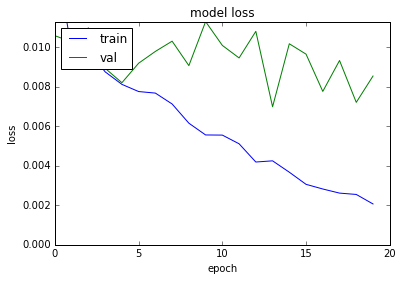

In [3]:
# Visualize training history
import matplotlib.pyplot as plt
import numpy

print(history.history.keys())
%matplotlib inline

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
axes = plt.gca()
axes.set_ylim([0,np.max(history.history['val_loss'][0:])])
plt.show()

In [4]:
def eval_and_save():
    test_samples = 3*int(1000/3)
    gen = threaded_generator(batch_generator(test_samples, 'test'))
    X_test, Y_test = next(gen)
    score = model.evaluate(X_test, Y_test, batch_size=batch_size)
    print('Test score (MSE): ', score)

    filepath = model_file.split('.')[0] + model_file.split('.')[1] + '-re-' + '%.4f' % score
    # save model architecture:
    json_string = model.to_json()
    import json
    with open(filepath + '.json', 'w') as outfile:
        json.dump(json_string, outfile)
    print('Model saved to ', filepath + '.json')
    # save weights:
    model.save_weights(filepath + '.h5')
    print('Weights saved to ', filepath + '.h5')

eval_and_save()

999/999 [==============================] - 6s     
Test score (MSE):  0.00868481756733
Model saved to  vgg16-pretrained-gen-00300-re-0.0087.json
Weights saved to  vgg16-pretrained-gen-00300-re-0.0087.h5
